# Data exploration
This notebook contains some tests about data import and some data viz tools

In [1]:
DATA_FOLDER = './data/'
MOVIES_FOLDER = DATA_FOLDER + 'movies_summaries/'
PLOT_SUMMARY_FOLDER = DATA_FOLDER + 'corenlp_plot_summaries'

REPORT_FOLDER = './gen/reports/'
ETHNICITY_FILE = './gen/ethnicities.tsv'

CHARACTERS_FILE = MOVIES_FOLDER + 'character.metadata.tsv'
MOVIES_FILE = MOVIES_FOLDER + 'movie.metadata.tsv'
PLOT_SUMMARIES_FILE = MOVIES_FOLDER + 'plot_summaries.txt'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
%matplotlib inline

# Characters

In [3]:
character_columns = ['wiki_movie_id', 'freebase_movie_id', 'm_release_date', 'name', 'a_dob', 'a_gender', 'a_height', 'a_ethnicity_freebase_id', 'a_name', 'a_age_at_release', 'freebase_char/a_map', 'freebase_char_id', 'freebase_a_id']
characters = pd.read_csv(CHARACTERS_FILE, sep='\t', names=character_columns, index_col=False)

print(characters.shape)
characters.head()   

(450669, 13)


,wiki_movie_id,freebase_movie_id,m_release_date,name,a_dob,a_gender,a_height,a_ethnicity_freebase_id,a_name,a_age_at_release,freebase_char/a_map,freebase_char_id,freebase_a_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [4]:
# generate profiling report
# profile_characters = ProfileReport(characters, title='Characters report')
# profile_characters.to_file(REPORT_FOLDER + "character_report_0.html")

# Movies

In [5]:
movies_columns = ['wiki_movie_id', 'freebase_movie_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv(MOVIES_FILE, sep='\t', names=movies_columns)

print(movies.shape)
movies.head()

(81741, 9)


,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [6]:
# generate profiling report
# profile_movies = ProfileReport(movies, title='Movies report')
# profile_movies.to_file(REPORT_FOLDER + "movies_report_0.html")

In [7]:
# Clean dates
# Remember that one movie contains 1010 date. We need to check what to do with it. Movie : Hunting Season, changes by hand at the moment
# Note: use .dt.date to recover the date only (not the datetime part)
print("Number of nan movies release dates: ", movies['release_date'].isna().sum())
movies['release_date'] = pd.to_datetime(movies['release_date'], format='%Y-%m-%d', errors='coerce')
movies.head()

Number of nan movies release dates:  6902


,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [8]:
print("Number of movies with box office revenue indicated: {} ({:.2%})".format(movies.shape[0] - movies['box_office_revenue'].isna().sum(), (movies.shape[0] - movies['box_office_revenue'].isna().sum())/movies.shape[0]))

# keep only movies with box office revenue
movies_without_na = movies[movies['box_office_revenue'].notna()]
print(movies_without_na.shape)

Number of movies with box office revenue indicated: 8401 (10.28%)
(8401, 9)


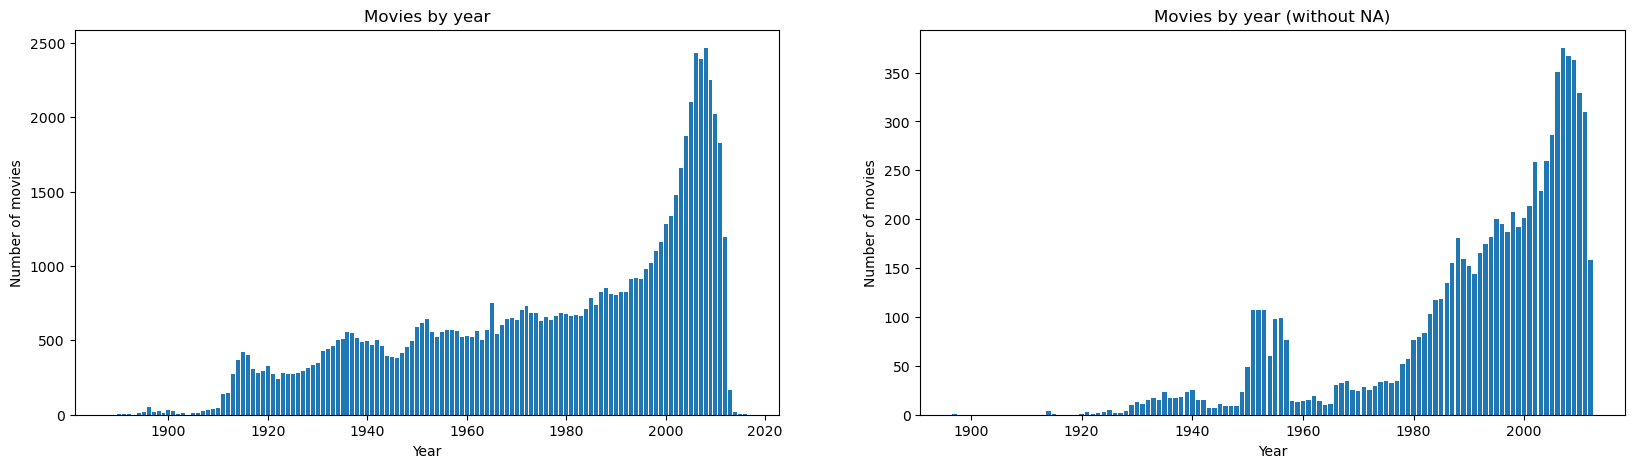

In [9]:
movies_by_year = movies.groupby(movies['release_date'].dt.year)['release_date'].count()
movies_by_year_without_na = movies_without_na.groupby(movies_without_na['release_date'].dt.year)['release_date'].count()

# plot values
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title('Movies by year')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of movies')
ax[0].bar(movies_by_year.index, movies_by_year.values)
# ax[0] = plt.bar(x=movies_by_year.index, y=movies_by_year.values, ax=ax[0], color='lightblue')
# ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

ax[1].set_title('Movies by year (without NA)')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of movies')
ax[1].bar(movies_by_year_without_na.index, movies_by_year_without_na.values)
plt.show()

In [10]:
## Get box office revenue by year
movies = movies_without_na
movies['box_office_revenue'] = movies['box_office_revenue'].astype(int)


In [11]:
def sort_by_box_office_revenue(df, k=10):
    return df.sort_values(by='box_office_revenue', ascending=False).head(k)

movies_by_year = movies.groupby(movies['release_date'].dt.year).apply(sort_by_box_office_revenue)
movies_by_year

wiki_movie_id freebase_movie_id  \
release_date                                          
1897.0       48417       28703057        /m/0czdh_n   
1914.0       49852       15130915        /m/03hjhh9   
             53319       15340505        /m/03m5kln   
             50991        1762869         /m/05tz4w   
             1026        14613957        /m/03gqmqv   
...                           ...               ...   
2012.0       78373       31186339        /m/0gkz15s   
             22008       13049327        /m/0661m4p   
             13702       16839300        /m/0407yfx   
             51913       31201599        /m/0gj9tn5   
             12076       31775043        /m/0gd0c7x   

                                             name release_date  \
release_date                                                     
1897.0       48417  The Corbett-Fitzsimmons Fight   1897-05-22   
1914.0       49852     The Million Dollar Mystery   1914-06-22   
             53319             Neptune's Daughter   1914-04-25   
             50991                  The Squaw Man   1914-02-15   
             1026              Rose of the Rancho   1914-11-15   
...                                           ...          ...   
2012.0       78373               The Hunger Games   2012-03-12   
             22008                 Men in Black 3   2012-05-14   
             13702                          Brave   2012-06-10   
             51913                            Ted   2012-06-29   
             12076                     Prometheus   2012-05-30   

                    box_office_revenue  runtime  \
release_date                                      
1897.0       48417              100000      NaN   
1914.0       49852             1500000      NaN   
             53319             1000000      NaN   
             50991              244700     74.0   
             1026                87028      NaN   
...                                ...      ...   
2012.0       78373           686533290    142.0   
             22008           624026776    103.0   
             13702           531957538     95.0   
             51913           488965740    106.0   
             12076           402480000    124.0   

                                                            languages  \
release_date                                                            
1897.0       48417                                                 {}   
1914.0       49852                 {"/m/02h40lc": "English Language"}   
             53319                 {"/m/02h40lc": "English Language"}   
             50991  {"/m/06ppq": "Silent film", "/m/02h40lc": "Eng...   
             1026   {"/m/06ppq": "Silent film", "/m/02h40lc": "Eng...   
...                                                               ...   
2012.0       78373                 {"/m/02h40lc": "English Language"}   
             22008                 {"/m/02h40lc": "English Language"}   
             13702                 {"/m/02h40lc": "English Language"}   
             51913                 {"/m/02h40lc": "English Language"}   
             12076  {"/m/01ncmg": "Gaelic", "/m/02h40lc": "English...   

                                                    countries  \
release_date                                                    
1897.0       48417                                         {}   
1914.0       49852  {"/m/09c7w0": "United States of America"}   
             53319  {"/m/09c7w0": "United States of America"}   
             50991  {"/m/09c7w0": "United States of America"}   
             1026   {"/m/09c7w0": "United States of America"}   
...                                                       ...   
2012.0       78373  {"/m/09c7w0": "United States of America"}   
             22008  {"/m/09c7w0": "United States of America"}   
             13702  {"/m/09c7w0": "United States of America"}   
             51913  {"/m/09c7w0": "United States of America"}   
             12076  {"/m/09c7w0": "United States of

In [12]:
# Get all characters of a movie
df = pd.merge(left=movies, right=characters, left_on='wiki_movie_id', right_on='wiki_movie_id', how='left', suffixes=('_m', '_c'))

# remove duplicated features
duplicate_columns = ['freebase_movie_id_c', 'm_release_date']
df = df.drop(duplicate_columns, axis=1)

df = df.rename(columns={'freebase_movie_id_m': 'freebase_movie_id'})
df

,wiki_movie_id,name_c,a_dob,a_gender,a_height,a_ethnicity_freebase_id,a_name,a_age_at_release,freebase_char/a_map,freebase_char_id,freebase_a_id,freebase_movie_id,name_m,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,975900,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
2,975900,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3,975900,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
4,975900,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
450665,913762,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
450666,28308153,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
450667,28308153,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN


# Import summaries

In [13]:
summaries = pd.read_csv(PLOT_SUMMARIES_FILE, sep='\t', index_col=0, names=['plot'])
summaries.index.name = 'wiki_movie_id'

In [14]:
df = pd.merge(left=df, right=summaries, left_on='wiki_movie_id', right_on='wiki_movie_id', how='left')
df

,wiki_movie_id,name_c,a_dob,a_gender,a_height,a_ethnicity_freebase_id,a_name,a_age_at_release,freebase_char/a_map,freebase_char_id,freebase_a_id,freebase_movie_id,name_m,release_date,box_office_revenue,runtime,languages,countries,genres,plot
0,975900,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,975900,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
2,975900,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
3,975900,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
4,975900,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,"The story takes place in the year 2092,The Sup..."
450665,913762,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,"The story takes place in the year 2092,The Sup..."
450666,28308153,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
450667,28308153,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


# Import ethnicities

In [15]:
ethnicities = pd.read_csv(ETHNICITY_FILE, sep='\t', header=None, names=['freebase_ethnicity_id', 'ethnicity_name'])
ethnicities

,freebase_ethnicity_id,ethnicity_name
0,/m/0x67,African Americans
1,/m/064b9n,Omaha people
2,/m/041rx,Jewish people
3,/m/033tf_,Irish Americans
4,/m/04gfy7,Indian Americans
...,...,...
425,/m/09r2kh,peoples of the Caucasus
426,/m/02ry8mk,Sierra Leone Creole people
427,/m/029q52,Georgians
428,/m/026d074,Goans


In [16]:
df = pd.merge(left=df, right=ethnicities, left_on='a_ethnicity_freebase_id', right_on='freebase_ethnicity_id', how='left')
df = df.drop(['freebase_ethnicity_id'], axis=1)
df = df.rename({'a_ethnicity_freebase_id': 'freebase_ethnicity_id'})
df.head()

,wiki_movie_id,name_c,a_dob,a_gender,a_height,a_ethnicity_freebase_id,a_name,a_age_at_release,freebase_char/a_map,freebase_char_id,...,freebase_movie_id,name_m,release_date,box_office_revenue,runtime,languages,countries,genres,plot,ethnicity_name
0,975900,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,...,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",NaN
1,975900,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,...,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",NaN
2,975900,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,...,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",African Americans
3,975900,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,...,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",NaN
4,975900,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,...,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",NaN


In [17]:
df

,wiki_movie_id,name_c,a_dob,a_gender,a_height,a_ethnicity_freebase_id,a_name,a_age_at_release,freebase_char/a_map,freebase_char_id,...,freebase_movie_id,name_m,release_date,box_office_revenue,runtime,languages,countries,genres,plot,ethnicity_name
0,975900,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,...,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",NaN
1,975900,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,...,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",NaN
2,975900,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,...,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",African Americans
3,975900,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,...,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",NaN
4,975900,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,...,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,"The story takes place in the year 2092,The Sup...",NaN
450665,913762,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,"The story takes place in the year 2092,The Sup...",NaN
450666,28308153,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,English people
450667,28308153,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
